In [19]:
#Implementation of a normal RNN with L1 regularization for comparision with the spatially embedded rnn.
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import pickle
import numpy as np
import scipy
import bct

In [20]:

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
hidden_size = 100
num_layers = 1
l1_lambda = 0.001
se1 = .001

# MAZE dataset
maze_data = mazeGeneratorI(goal_presentation_steps=20,delay_steps=10,choices_presentation_steps=20)
train_dataset_maze = maze_data.construct_pt_data(5120,True)
test_dataset_maze = maze_data.construct_pt_data(2000)
print("Generated Data...")
train_loader = DataLoader(dataset=train_dataset_maze, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset_maze, batch_size=batch_size, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Generated Data...
cuda


In [21]:
def compute_modularity(recurrent_weight):
    thresh = np.quantile(recurrent_weight,.9)
    mask = recurrent_weight > thresh
    binary_weights = np.zeros(recurrent_weight.shape)
    binary_weights[mask] = 1
    _, mod = bct.modularity_und(binary_weights,gamma=1)
    return mod


def compute_small_worldness(recurrent_weight):
    thresh = np.quantile(recurrent_weight,.9)
    mask = recurrent_weight > thresh
    binary_weights = np.zeros(recurrent_weight.shape)
    binary_weights[mask] = 1
    A = binary_weights
    clu = np.mean(bct.clustering_coef_bu(A))
    pth = bct.efficiency_bin(A)
    # Run nperm null models
    nperm = 1000
    cluperm = np.zeros((nperm,1))
    pthperm = np.zeros((nperm,1))
    for perm in range(nperm):
        Wperm = np.random.rand(100,100)
        # Make it into a matrix
        Wperm = np.matrix(Wperm)
        # Make symmetrical
        Wperm = Wperm+Wperm.T
        Wperm = np.divide(Wperm,2)
        # Binarise
        threshold, upper, lower = .7,1,0
        Aperm = np.where(Wperm>threshold,upper,lower)
        # Take null model
        cluperm[perm] = np.mean(bct.clustering_coef_bu(Aperm))
        pthperm[perm] = bct.efficiency_bin(Aperm)
    # Take the average of the nulls
    clunull = np.mean(cluperm)
    pthnull = np.mean(pthperm)
    # Compute the small worldness
    smw = np.divide(np.divide(clu,clunull),np.divide(pth,pthnull))
    return smw

In [22]:
class SE1():
    
    """
    Spatially Embedded L1 Regularization for RNN's, specifically the recurrent kernel Weighted by distnce of units in predefined 3d Space.
    Calc: se1 * sum[distance_matrix * recurrent kernel].

    se1: Scaling constant for regularization, like lambda_1 or lambda_2.
    neuron_num: Number of neurons in recurrent kernel
    network_shape: Supposed 3d shape of all neurons, could probably get really creative with this.
    """
    def __init__(self,se1=0.001, neuron_num = 100,network_shape = (5,5,4),device="cpu",min_self_cost=False):
        #Set up coordinate matrix
        if neuron_num != network_shape[0] * network_shape[1] * network_shape[2]:
            raise ValueError("Number of neurons specified does not match network shape")
        #Use coordinate matrix to get distance matrix
        nx = np.arange(network_shape[0])
        ny = np.arange(network_shape[1])
        nz = np.arange(network_shape[2])
        x,y,z = np.meshgrid(nx,ny,nz)
        self.se1 =se1
        self.coordinates = [x.ravel(),y.ravel(),z.ravel()]
        euclidean_vector = scipy.spatial.distance.pdist(np.transpose(self.coordinates),metric="euclidean")
        euclidean = scipy.spatial.distance.squareform(euclidean_vector)
        
        self.distance_matrix = euclidean.astype('float32')
        self.spatial_cost = torch.from_numpy(self.distance_matrix).to(device)
    def __call__(self,model):
        weight = model.state_dict()["rnn.weight_hh_l0"]
        return self.se1 * torch.sum(weight * self.spatial_cost)
    
    def visualize_neuron_structure(self):
        fig = plt.figure()

        ax = Axes3D(fig)
        ax.scatter(self.coordinates[0],self.coordinates[1],self.coordinates[2],c='b',marker=".")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

class SE1_sWc(SE1):
    """
    Spatially Embedded L1 Regularization for RNNS', combining both spatial and communicability parts in the loss function.
    
    """
    def __init__(self,se1=.001,neuron_num=100,network_shape = (5,5,4),device="cpu",min_self_cost = False,comms_factor = 1):
        SE1.__init__(self,se1,neuron_num,network_shape,device,min_self_cost)
        self.comms_factor = comms_factor

    def __call__(self,model):
        abs_weights = model.state_dict()["rnn.weight_hh_l0"].abs()

        #Calculating weighted communicability
        stepI = torch.sum(abs_weights,axis=1)
        stepII = torch.pow(stepI,-0.5)
        stepIII = torch.diag(stepII)
        stepIV = torch.matrix_exp(stepIII @ abs_weights @ stepIII)
        n = stepIV.shape[0]
        stepIV[torch.eye(n) == 1] = 0
        comms_matrix = stepIV * self.comms_factor
        se1_loss = self.se1 * torch.sum(comms_matrix * self.spatial_cost)
        return se1_loss


        

In [23]:
# RNN Model

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Initialize model, loss function, and optimizer
model = RNN(input_size=8, hidden_size=hidden_size, num_layers=num_layers, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
spatial_loss = SE1_sWc(device=device,se1=se1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#Normal L1 Regression
def l1_reg_non_recurrent(model,l1_lambda):
    #L1 regularization only on non recurrent weights -> SE1 takes care of regularization of recurrent parameters
    return l1_lambda * sum([weight.abs().sum() for name, weight in model.named_parameters() if name != "rnn.weight_hh_l0"])
#Normal L2 Regression
def l2_reg_non_recurrent(model,l1_lambda):
    #L2 regularization only on non recurrent weights -> SE1 takes care of regularization of recurrent parameters
    return l1_lambda * sum([weight.pow(2).sum() for name, weight in model.named_parameters() if name != "rnn.weight_hh_l0"])
spatial_loss.visualize_neuron_structure()

<Figure size 640x480 with 0 Axes>

In [24]:

losses = []
modularity = []
small_worldness = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.squeeze(1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss += spatial_loss(model) + l2_reg_non_recurrent(model,l1_lambda)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            losses.append(loss.item())
            numpy_weight = model.state_dict()["rnn.weight_hh_l0"].detach().cpu().numpy()
            modularity.append(compute_modularity(numpy_weight))
            small_worldness.append(compute_small_worldness(numpy_weight))

# Evaluation
model.eval()
correct = 0
total = 0
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted[:,np.newaxis] == labels).sum().item()

print(f'Accuracy of the model on the 10000 test data: {100 * correct / total}%')


Epoch [1/20], Step [50/80], Loss: 0.9786


C:\Users\ankit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Epoch [2/20], Step [50/80], Loss: 0.5450
Epoch [3/20], Step [50/80], Loss: 0.5344
Epoch [4/20], Step [50/80], Loss: 0.5321
Epoch [5/20], Step [50/80], Loss: 0.5312
Epoch [6/20], Step [50/80], Loss: 0.5307
Epoch [7/20], Step [50/80], Loss: 0.5303
Epoch [8/20], Step [50/80], Loss: 0.5299
Epoch [9/20], Step [50/80], Loss: 2.4638
Epoch [10/20], Step [50/80], Loss: 1.3089
Epoch [11/20], Step [50/80], Loss: 1.1821
Epoch [12/20], Step [50/80], Loss: 1.0277
Epoch [13/20], Step [50/80], Loss: 1.0203
Epoch [14/20], Step [50/80], Loss: 0.9068
Epoch [15/20], Step [50/80], Loss: 0.8644
Epoch [16/20], Step [50/80], Loss: 1.2030
Epoch [17/20], Step [50/80], Loss: 0.9249
Epoch [18/20], Step [50/80], Loss: 0.8574
Epoch [19/20], Step [50/80], Loss: 0.8949
Epoch [20/20], Step [50/80], Loss: 0.8580
Accuracy of the model on the 10000 test data: 74.6%


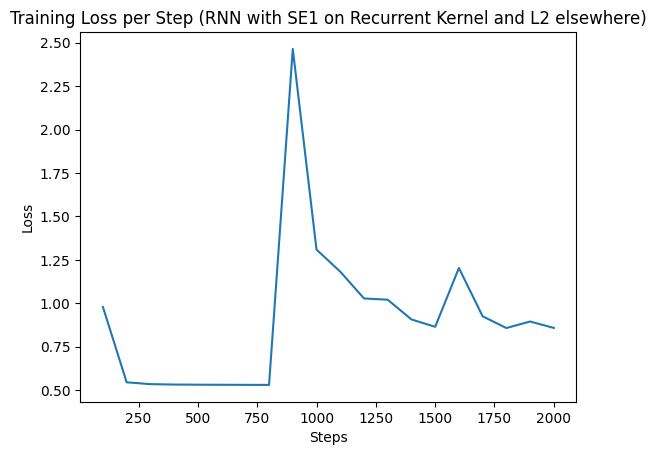

In [25]:
%matplotlib inline
plt.plot(np.array(range(1,len(losses)+1)) * 100,losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss per Step (RNN with SE1 on Recurrent Kernel and L2 elsewhere)")
plt.show()

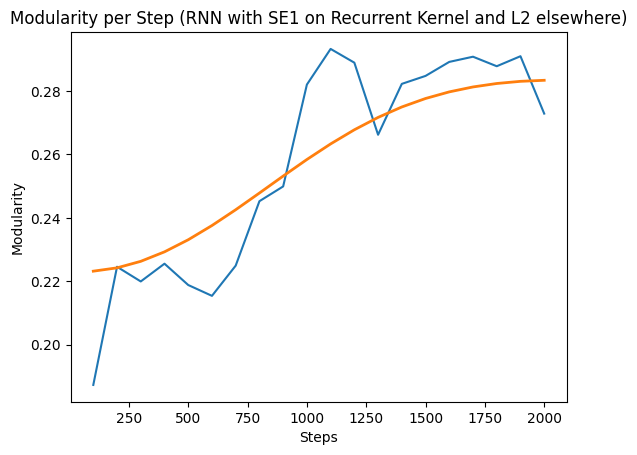

In [26]:
#Figure out a way to graph the small-worldness etc.
#Compute modularity of both forward layer or just rnn layer?

#Need to split it, create a function that calculates modularity, then graph the modularity as we go on.
from scipy.ndimage import gaussian_filter1d
smoothed_mod = gaussian_filter1d(modularity,5)

plt.plot(np.array(range(1,len(losses)+1)) * 100,modularity)
plt.plot(np.array(range(1,len(losses)+1)) * 100,smoothed_mod,linewidth=2)
plt.xlabel("Steps")
plt.ylabel("Modularity")
plt.title("Modularity per Step (RNN with SE1 on Recurrent Kernel and L2 elsewhere)")
plt.show()

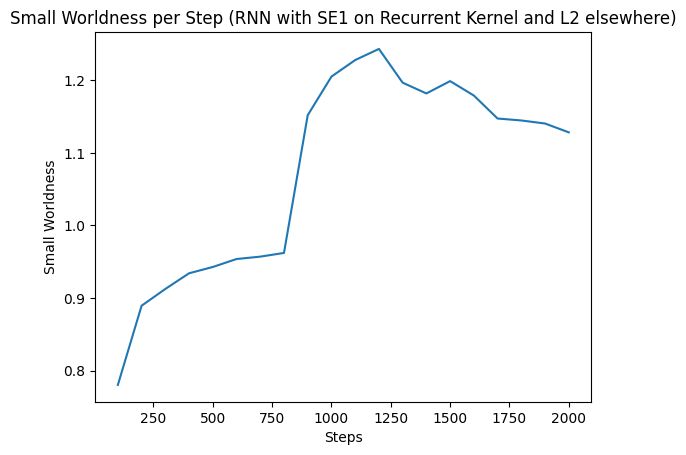

In [27]:
#Figure out a way to graph the small-worldness etc.
#Compute modularity of both forward layer or just rnn layer?

#Need to split it, create a function that calculates modularity, then graph the modularity as we go on.
#Only once per epoch because its expensive
plt.plot(np.array(range(1,len(losses)+1)) * 100,small_worldness)
plt.xlabel("Steps")
plt.ylabel("Small Worldness")
plt.title("Small Worldness per Step (RNN with SE1 on Recurrent Kernel and L2 elsewhere)")
plt.show()

In [28]:
with open("spatial_embedded_rnn_maze.pkl","wb") as f:
    pickle.dump(losses,f)
    pickle.dump(modularity,f)
    pickle.dump(small_worldness,f)